Recordatorio: si se está trabajando en un contenedor recien instalado, va a ser necesario instalar git-hub todas las librerias requeridas

## Alumno: Alex Barria

## Vision Transformer (ViT)

El **Vision Transformer (ViT)** es un modelo innovador para la clasificación de imágenes que transforma las imágenes en secuencias de parches más pequeños, comúnmente de $16 \times 16$ píxeles, como se describe en el paper de [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy)  "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Cada parche se considera como una "palabra" o "token" y se proyecta en un espacio de características. Mediante la incorporación de cifrados de posición y un token de clasificación, podemos aplicar un Transformer de manera convencional a esta secuencia, permitiendo su entrenamiento para tareas de clasificación de imágenes.

## Embeddings y Cifrado de Posición

### Embeddings
En el contexto de ViTs, las imágenes son primero divididas en pequeños bloques o patches (como si se cortaran en pequeños cuadrados). Estos patches se tratan como si fueran palabras en un modelo de lenguaje, y a cada uno se le asigna un embedding. Un embedding es simplemente una representación numérica del patch en un espacio de alta dimensión que captura características relevantes del mismo.

Por ejemplo, si divides una imagen de 224x224 píxeles en 16x16 bloques, tendrás 196 patches en total. Cada uno de esos patches se convierte en un vector de embedding, que luego se alimenta al modelo Transformer.

### Positional Embedding (Cifrado Posicional):

El **embedding posicional** agrega información sobre la ubicación de cada parche en la imagen original. En el paper de Alexey Dosovitskiy et al., se evaluaron varias formas de codificar la información espacial con embebidos posicionales. Se observó que, aunque el uso de embebidos mejora el rendimiento en comparación con no usarlos, no hay diferencias significativas entre los métodos probados. Se concluyó que, dado que el modelo opera a nivel de parches en lugar de píxeles, la forma específica de codificar la posición es menos relevante.
## Proceso de Creación de Embeddings

1. **División en Parches**: La imagen se divide en parches de $N \times N$ píxeles.
   
2. **Generación de Embeddings**: Cada parche se transforma en un embedding que captura su información relevante.

3. **Cifrado de Posición**: Se añade un vector de cifrado de posición a cada embedding. 

   Algunos ejemplos del cifrado:


   *  **Codificación Sinusoidal:** La fórmula sinusoidal para embebidos posicionales (tradicional en Transformers-NLP) genera los valores de los embebidos en función de senos y cosenos. Estos valores dependen directamente de la posición y siguen una periodicidad específica para capturar relaciones posicionales. Es determinista y no se ajusta durante el entrenamiento, ya que los valores están calculados y fijos para cada posición.
   Donde:
       - $pos$ es la posición en la secuencia.
       - $i$ es el índice de la dimensión.
       - $d_{model}$ es la dimensión del modelo.

   $$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

   $$PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$



   * **Embebido Posicional Aprendido (a ser implementada por el alumno):** los embebidos posicionales se definen como un parámetro de la red neuronal (usando [nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)), lo que significa que los valores para el embebido  posicional se aprenden durante el proceso de entrenamiento. Se define embedding, matriz de tamaño (1, num_patches, embed_dim), donde num_patches es el número de parches (posiciones) en la secuencia de la imagen y  embed_dim es la dimensión de los embebidos. La inicialización torch.randn genera valores aleatorios para estos embebidos posicionales, y luego el modelo los optimiza durante el entrenamiento, ajustando los valores en función de los gradientes.

4. **Combinación de Embeddings y Cifrado de Posición**: Se suma cada embedding con su correspondiente cifrado de posición, generando un vector final que contiene tanto la información del contenido del parche como su posición en la imagen.

El resultado es una serie de vectores, cada uno representando un parche y su posición, que se alimentan a las capas del Transformer. Esto permite al modelo aprender no solo sobre las características individuales de cada parche, sino también sobre cómo estos se relacionan entre sí en el contexto de la imagen completa.


![Vision Transformer](vit.gif)

*Crédito: [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)*


A continuación, trabajaremos con los **patch embeddings** y la **codificación posicional**, esenciales para que el modelo pueda interpretar las relaciones espaciales en las imágenes. 

## Tareas:

1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 


Dispositivo utilizado: mps


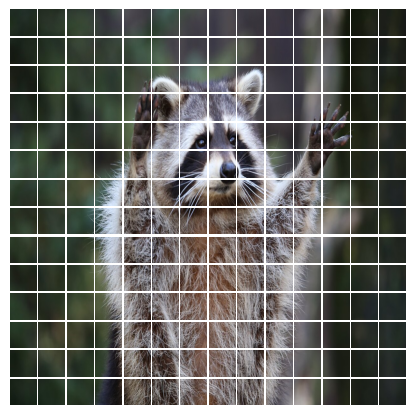

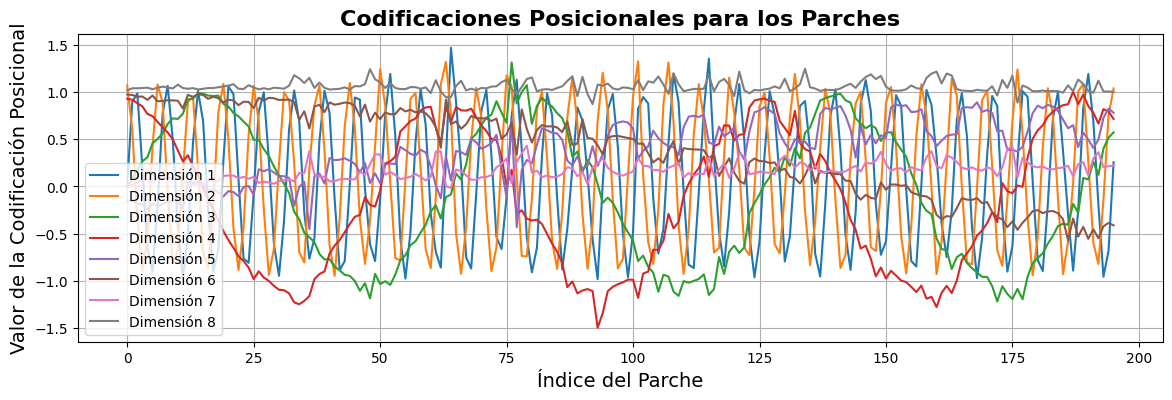

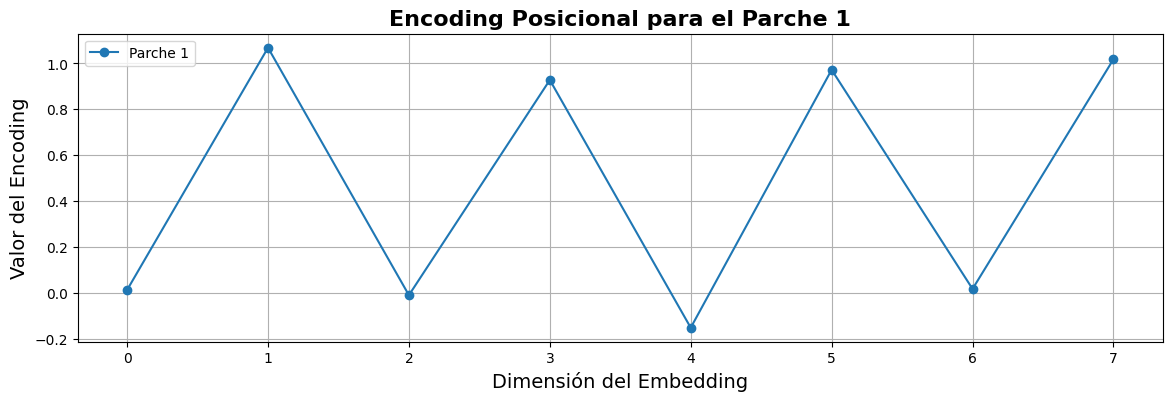

In [15]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')
        
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))  # (1, num_patches, embed_dim)

    def forward(self, x):
        return x + self.pos_embedding

class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()




# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)




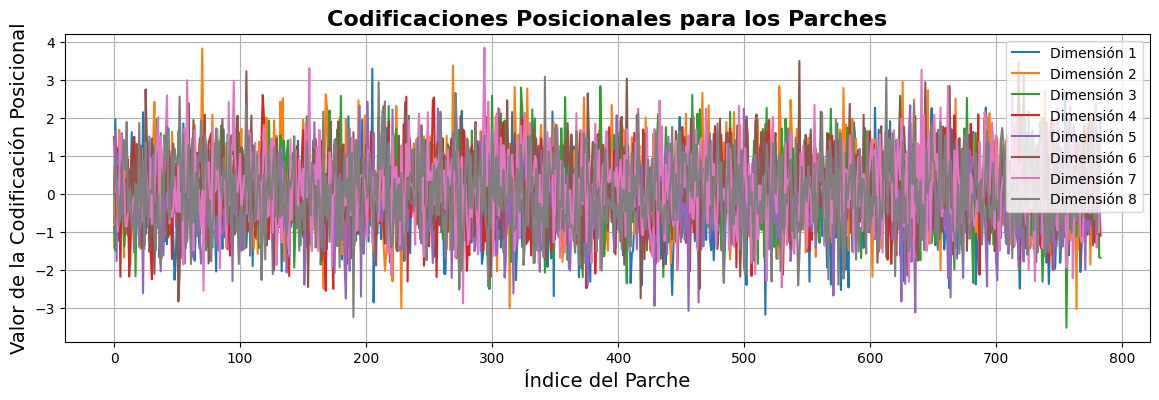

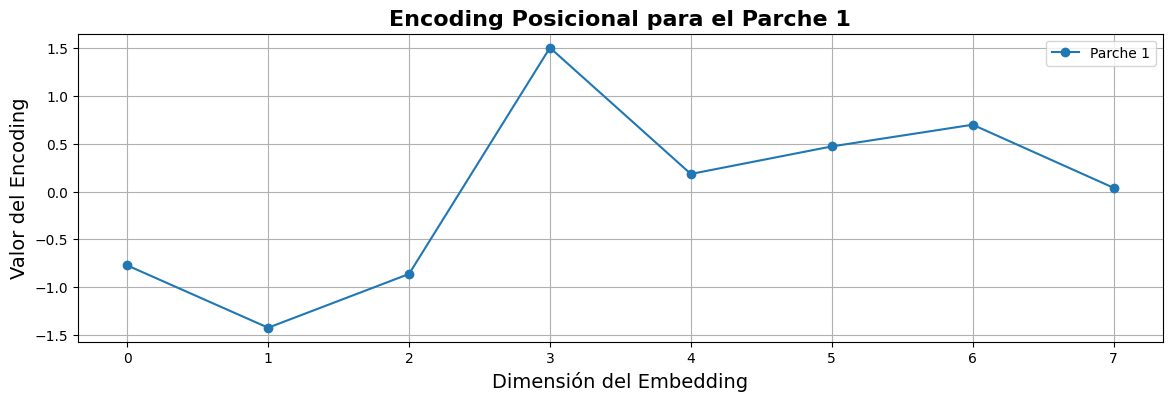

In [5]:
# Codificación posicional aprendida
positional_encoding_learned = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
pos_embeddings_learned = positional_encoding_learned(patches)

# Visualizaciones
Visualization.visualize_positional_encoding(pos_embeddings_learned)
Visualization.visualize_single_patch_encoding(pos_embeddings_learned, patch_idx)

## Solución
>1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

## 🔍 Análisis sobre el Tamaño de Parche y la Dimensión del Embedding

En este experimento se evaluaron distintas configuraciones de tamaño de parche (`patch_size`) y dimensión del embedding (`embed_dim`). En particular, se analizaron tamaños de parche de **32**, **64** y **128** píxeles, para estudiar cómo afectan a la granularidad de la representación y a la codificación posicional.


### 📐 Tamaño del Parche (`patch_size`)

**✅ Ventajas de usar parches más pequeños (por ejemplo, 32):**
- Mayor **granularidad**: cada parche captura una porción más pequeña de la imagen, útil para detectar detalles finos.
- Se generan más parches, lo cual permite modelar **relaciones espaciales más precisas**.
- Útil en tareas que dependen de información local, como detección de bordes o texturas.

**⚠️ Desventajas:**
- Aumenta la **longitud de la secuencia** de entrada, lo cual incrementa el **costo computacional**.
- Puede dificultar la integración de contexto global si no se entrena adecuadamente.

**✅ Ventajas de usar parches más grandes (por ejemplo, 128):**
- Capturan regiones más amplias de la imagen, facilitando el análisis de **estructura global**.
- Se reduce el número total de parches, disminuyendo el **uso de memoria y tiempo de cómputo**.

**⚠️ Desventajas:**
- Se pierde **información local detallada**.
- Menor resolución espacial de la imagen original en la representación del modelo.

### 🖼️ Ejemplos visuales de división por parches

A continuación se muestran ejemplos del mismo input dividido con diferentes tamaños de parche. Se puede observar cómo varía la granularidad de la representación.

#### 📏 Tamaño de parche: 32x32
![Parches 32x32](./Images/patches_32.png)

#### 📏 Tamaño de parche: 64x64
![Parches 64x64](./Images/patches_64.png)

#### 📏 Tamaño de parche: 128x128
![Parches 128x128](./Images/patches_128.png)
- En la figura con `patch_size = 32`, se observa una cuadrícula densa, lo que permite una segmentación muy detallada.
- Con `patch_size = 64`, se logra un **equilibrio** entre resolución y eficiencia.
- En `patch_size = 128`, la cantidad de parches es baja, lo que reduce la complejidad, pero también la riqueza de representación.


### 🔢 Dimensión del Embedding (`embed_dim`)

**✅ Ventajas de mayor dimensión (por ejemplo, 64 o 128):**
- Mayor **capacidad representacional** para capturar patrones complejos.
- Mejora el poder expresivo del modelo.

**⚠️ Desventajas:**
- Más parámetros → mayor riesgo de **overfitting** si no se cuenta con suficientes datos.
- Requiere **más memoria y poder computacional**.

**✅ Ventajas de menor dimensión (por ejemplo, 8 o 16):**
- Modelo más **ligero** y rápido.
- Menor riesgo de sobreajuste en datasets pequeños.

**⚠️ Desventajas:**
- Capacidad limitada para representar variaciones visuales sutiles.
- Menor poder expresivo.


### ✅ Conclusión

La elección del `patch_size` y `embed_dim` representa un **trade-off entre granularidad, capacidad de representación y eficiencia computacional**.

- Para tareas donde los **detalles locales** son clave, conviene usar parches más pequeños y embeddings de mayor dimensión.
- Para tareas más globales o cuando se busca **eficiencia**, se puede optar por parches grandes y embeddings más reducidos.

En definitiva, la configuración ideal depende del **contexto de la tarea**, los **recursos disponibles** y la **cantidad de datos para entrenar** el modelo.


---


> 2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 

Para resolver este punto, se creó la clase `PositionalEncodingLearned` que utiliza `nn.Parameter` y `torch.randn` para crear una matriz de valores que se inicializan con valores aleatorios y luego se van actualizando en los sucesivos pasajes fordward durante el entrenamiento del modelo.

La gráfica inicial de estos encodings, como es de esperar, muestra patrones aleatorios al comienzo. Como se pueden ver en la siguiente imagen:
![Learned embeddings](./Images/embeddings_learned.png)

### ✅ Conclusión

La implementación de la clase `PositionalEncodingLearned` permitió incorporar una codificación posicional **aprendida** como alternativa a la codificación sinusoidal estática. A diferencia de esta última, los embeddings posicionales aprendidos se inicializan con valores aleatorios y tienen la capacidad de **adaptarse durante el entrenamiento**, optimizándose según la tarea específica.

Esto representa una ventaja potencial frente a las codificaciones fijas, ya que el modelo puede ajustar las representaciones posicionales en función de lo que aprende, permitiendo una mayor **flexibilidad y expresividad**. Sin embargo, también introduce un mayor riesgo de sobreajuste si no se cuenta con suficiente cantidad de datos o regularización adecuada.

En resumen, los embebidos posicionales aprendidos ofrecen una solución más dinámica que puede mejorar el rendimiento del modelo, aunque requieren entrenamiento para alcanzar su verdadero potencial, ya que en su estado inicial no contienen información estructurada, como se observa en la visualización adjunta.